### Why do different orders have different median recovery accuracies?

#### 1. Does it come from the injection process itself?

In [43]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import math
from scipy.interpolate import interp1d
from mpmath import mp
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)
import import_ipynb
from rescale import get_rescaled_wave_soln
wave_soln_ref = get_rescaled_wave_soln()

importing Jupyter notebook from rescale.ipynb
Finished rescale


In [2]:
# function to insert simulated gaussians
def insert_gaussian(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] # position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be odd
    gauss = gaussian(x,height,position,FWHM/(2*np.sqrt(2*np.log(2))),offset)
    new_spect = spectrum
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = spectrum[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] + gauss
    return new_spect
    
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

Star: HIP7513
rcbg.508.fits: 
injecting signal of W = 5, H = 1.5*(local median) = 34698.146. 
injecting at center point 5461.813824900171 A, order 39
injecting signal of W = 5, H = 2*(local median) = 46404.531. 
injecting at center point 5526.772619756325 A, order 40
injecting signal of W = 5, H = 3*(local median) = 70940.467. 
injecting at center point 5593.298646595918 A, order 41
rcbg.509.fits: 
injecting signal of W = 5, H = 1.5*(local median) = 33579.299. 
injecting at center point 5461.813824900171 A, order 39
injecting signal of W = 5, H = 2*(local median) = 44986.535. 
injecting at center point 5526.772619756325 A, order 40
injecting signal of W = 5, H = 3*(local median) = 68968.207. 
injecting at center point 5593.298646595918 A, order 41
rcbg.510.fits: 
injecting signal of W = 5, H = 1.5*(local median) = 33496.954. 
injecting at center point 5461.813824900171 A, order 39
injecting signal of W = 5, H = 2*(local median) = 44879.531. 
injecting at center point 5526.772619756325 

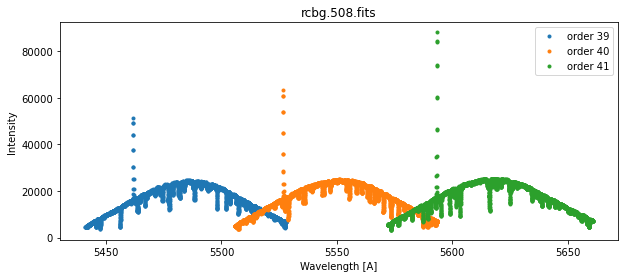

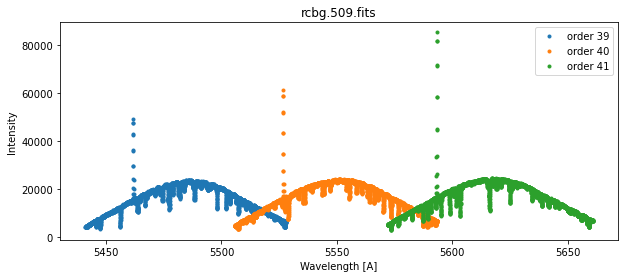

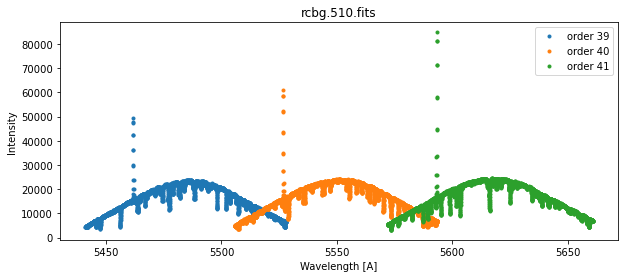

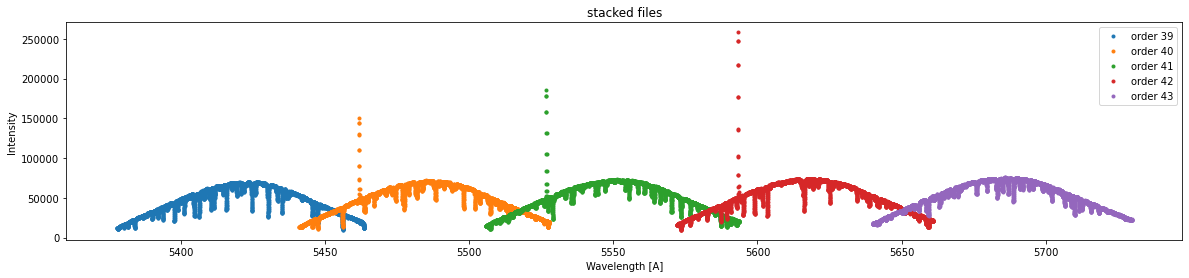

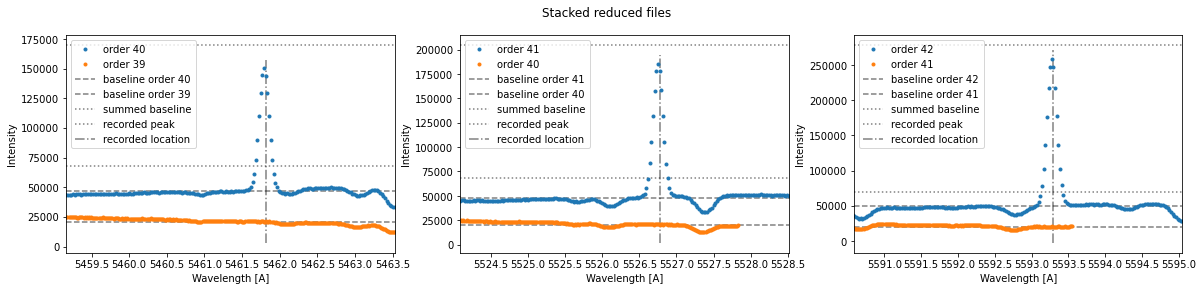

In [216]:
# ---------- Edges --------- #
save_key =  False
save_injected_files = False

star = 'HIP7513' #os.listdir('APF_spectra/all_apf_spectra_highest_SNR')[0:300]
n_stars = 1
    
heights = [1.5, 2, 3] # times the 98th percentile of order 40

apf_wave = fits.open('apf_wav.fits')
injected_peak_photons = np.zeros(n_stars*3) # *3 becuase three different inejctions in each star
median_photons_100_pix = np.zeros(n_stars*3)
median1_photons_100_pix = np.zeros(n_stars*3)
median2_photons_100_pix = np.zeros(n_stars*3)
injection_wl = np.zeros(n_stars*3)*np.nan
stars = []
    
for m in range(3): stars += [star] # want three entries for this star: one for each injection
dir_path = 'APF_spectra/all_apf_spectra_highest_SNR/' + star + '_spectra'
i = 0
print('Star: ' + star)

stacked = np.zeros([5,4608])

for file in os.listdir(dir_path):
    hdu = fits.open(dir_path + '/' + file)# , mode='update')
    spectrum = np.copy(hdu[0].data)
    color = 'C' + str(i)  
    n = 0
    orders = [39, 40, 41]
    y = hdu[0].data
    print(file + ': ')
    plt.figure(figsize = [10,4])
    for height in heights:
        # Inject into the first of the overlapping orders
        order = orders[n] # inject the 1.5 hieght into order 39, 2 into order 40, etc
        x = apf_wave[0].data[order]
        frac = 5
        y_order = y[order]
        injection_center_wl = apf_wave[0].data[order][int(len(y_order)/frac)] # deliberately inject into the order edge (overlapping region)
        h = height - 1 # becuase in the above implementation we add to the baseline, so ie. h = 1 injects a guassian whose peak is at twice the pixels value of the 98th percentile  
        # is this close to ok near edges??
        median_100 = np.median(y_order[int(len(y_order)/frac - 50): int(len(y_order)/frac + 50)])
        second_order = order - 1
        y_second_order = y[second_order] 
# -------------------------------------------------- THIS SECTION ADDED ------------------------------------------------ #
        # for the second order's median, first find where to take the median
        median_center_wl = x[int(len(y_order)/frac)]
        x2 =  apf_wave[0].data[order -1]
        median2_center_loc = np.absolute(x2 - median_center_wl).argmin()
        second_median_100 = np.median(y_second_order[median2_center_loc - 50: median2_center_loc + 50]) 
# ------------------------------------------------- ^THIS SECTION ADDED^ -------------------------------------------------- #
        combined_median_100 = median_100 + second_median_100
        num_photons = height * combined_median_100
        y_new = insert_gaussian(y_order, [num_photons, 49, 5, 0], int(len(y_order)/frac), 100)
        print('injecting signal of W = 5, H = ' + str(height) + 
              '*(local median) = ' + str(np.round(num_photons,3)) + '. ')
        print('injecting at center point ' + str(injection_center_wl) + ' A, order ' + str(order))

        plt.plot(x, y_new[:-1], '.', label = 'order ' + str(order))
        plt.title(file)
        plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity'); plt.legend()
        
        #plt.xlim([5553,5557])
        injected_peak_photons[n] = injected_peak_photons[n] + height * combined_median_100 # sum over each file
        median_photons_100_pix[n] = median_photons_100_pix[n] + combined_median_100 # sum over each file
        median1_photons_100_pix[n] = median1_photons_100_pix[n] + median_100 # sum over each file
        median2_photons_100_pix[n] = median2_photons_100_pix[n] + second_median_100 # sum over each file
        injection_wl[n] = injection_center_wl # same for each file (and each star)
        spectrum[order,:] = y_new
        
        # add each file
        stacked[order - 39 + 1,:] += y_new # the plus 1 is becuase stacked contains the two adjacent orders as well
        
        n += 1
    
    stacked[0] += y[38]
    stacked[4] += y[42]
    
    #plt.figure()
    #for order in np.arange(38,43,1):
    #    plt.plot(apf_wave[0].data[order], spectrum[order,:-1])
    #    plt.title(star + ', ' + file)
    i += 1

    if save_injected_files:
        new_header = hdu[0].header # get header
        new_header.set('Injected', 'YES','Spectrum contains injected gaussian for testing.')
        data_hdu = fits.PrimaryHDU(spectrum, new_header) 
        hdu_new = fits.HDUList([data_hdu])
        out_path = 'APF_spectra/injected_spectra_9/'
        if not os.path.isdir(out_path + star + '_spectra/'):
            os.mkdir(out_path + star + '_spectra/')
        hdu_new.writeto(out_path + star + '_spectra/' + file + '_injected' + '.fits')
        hdu.close()
    

plt.figure(figsize = [20,4])
for order in [0, 1, 2, 3, 4]:
    plt.plot(apf_wave[0].data[order + 38], stacked[order,:-1], '.', label = 'order ' + str(order + 39))
    plt.title('stacked files')
    plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity'); plt.legend()
    
plt.figure(figsize = [20,4])
for order in [1, 2, 3]:
    plt.subplot(1,3,order)
    x1 = apf_wave[0].data[order + 38]
    x2 = apf_wave[0].data[order - 1 + 38]
    plt.xlim([x1[800], x1[1000]])
    plt.plot(x1, stacked[order,:-1], '.', label = 'order ' + str(order + 39))
    plt.plot(x2, stacked[order - 1,:-1], '.', label = 'order ' + str(order + 39 - 1))
    ymin, ymax = plt.gca().get_ylim()
    xmin, xmax = plt.gca().get_xlim()
    # this won't work becuase the baseline is for BOTH overlapping orders combined
    plt.hlines([median1_photons_100_pix[order -1]], xmin = xmin, xmax = xmax, ls = 'dashed', alpha = 0.5, label = 'baseline order ' + str(order + 39))
    plt.hlines([median2_photons_100_pix[order -1]], xmin = xmin, xmax = xmax, ls = 'dashed', alpha = 0.5, label = 'baseline order ' + str(order + 39 - 1))
    plt.hlines([median_photons_100_pix[order -1]], xmin = xmin, xmax = xmax, ls = 'dotted', alpha = 0.5, label = 'summed baseline')
    plt.hlines([injected_peak_photons[order -1] + median_photons_100_pix[order-1]], xmin = xmin, xmax = xmax, ls = 'dotted', alpha = 0.5, label = 'recorded peak')  
    plt.vlines([injection_wl[order - 1]], ymin = ymin, ymax = ymax, ls = '-.', alpha = 0.5, label = 'recorded location')
    plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity'); plt.legend()
plt.suptitle('Stacked reduced files')
    

if save_key:
    save_data = list(zip(stars, injection_wl, injected_peak_photons, median_photons_100_pix))
    df = pd.DataFrame(save_data,
              columns = ['Star_name', 'Injection_wavelength', 'Injected_peak_photons', 'Local_median_photons'])
    if os.path.exists('Injection_key_9.csv'):
        df.to_csv('Injection_key_9.csv', mode='a', index = False, header=False)
    else:
        df.to_csv('Injection_key_9.csv', index = False)

Text(0.5, 0.98, 'stacked files')

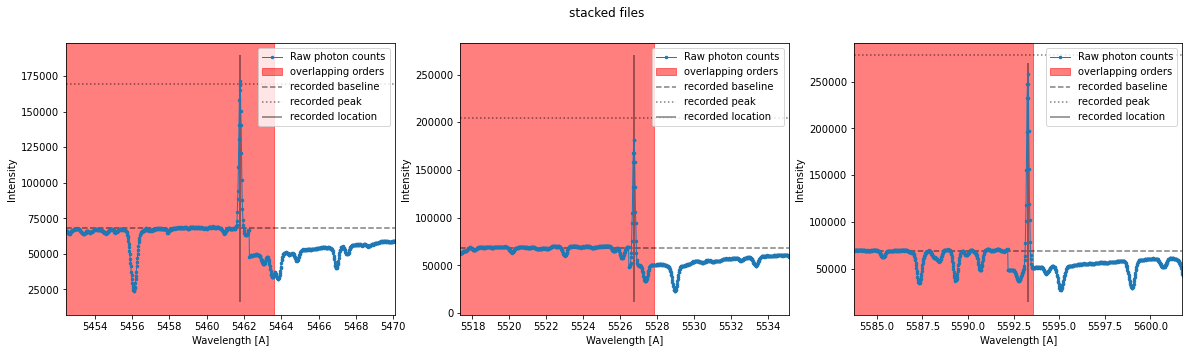

In [131]:
# read in the raw photon counts after stacking and resampling the orders
photon_counts = np.array(pd.read_csv('SM_photon_counts_all_injections/test_' + '9' + '/photon_counts_' + star + '.csv'))
hdu_unshifted = fits.open('APF_spectra/NDRU_testing_inj_' + '9' + '/' + star + '_NDRU.fits')
wl_unshifted = hdu_unshifted[1].data

plt.figure(figsize = [20,5])
for order in range(3):
    plt.subplot(1,3,order+1)
    low_bound = apf_wave[0].data[order + 39, 0]#500#[38,0]
    up_bound = apf_wave[0].data[order + 39, -1]#-3000#[42,-1]
    idxs_raw = (wave_soln_ref > low_bound) * (wave_soln_ref < up_bound)
    idxs_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
      
    x = wl_unshifted[idxs_unshifted]
    #plt.xlim([x[800], x[1000]])
    ms = 5; lw = 1
    plt.plot(x, photon_counts[idxs_raw], '.-', ms = ms, lw = lw, label = 'Raw photon counts')
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    # this won't work becuase the baseline is for BOTH overlapping orders combined
    plt.hlines([median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dashed', alpha = 0.5, label = 'recorded baseline')
    plt.hlines([injected_peak_photons[order] + median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dotted', alpha = 0.5, label = 'recorded peak')  
    ax.axvspan(apf_wave[0].data[order + 39, 0], apf_wave[0].data[order + 39 - 1, -1], alpha=0.5, color='red', label = 'overlapping orders')#fill_betweenx(y, x1, x2=0,
    plt.vlines([injection_wl[order]], ymin = ymin, ymax = ymax, ls = 'solid', alpha = 0.5, label = 'recorded location')
    plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity'); plt.legend()
    plt.xlim([apf_wave[0].data[order + 39, 500], apf_wave[0].data[order + 39, -3300]])
plt.suptitle('stacked files')

#### 2)  Is it in the recovery?


In [125]:
import os
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from mpmath import mp
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)
from astroquery.simbad import Simbad
import sys
gaia_values = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/gaia_values.csv')
velocity_shifts = pd.read_csv('Velocity_shift_inj_8.csv') #velocity_shifts = pd.read_csv('Velocity_shift_all_targets_updated.csv')
apf_wl_soln = fits.open('apf_wav.fits')[0].data
import import_ipynb
from rescale import get_rescaled_wave_soln
wave_soln_ref = get_rescaled_wave_soln()
c = 2.99 * 10**5 # km/s

# define gaussian function for fitting
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f.astype(float)

# define function to get Gaia names
def get_names(sim_name):
    # get Gaia and 2MASS names 
    result_table = Simbad.query_objectids(sim_name)
    names = result_table.to_pandas()['ID'].to_list()
    gaia_name = [name.decode('utf-8').split(' ')[-1] for name in names if name.decode('utf-8').startswith('Gaia DR2')]
    two_MASS_name = [name.decode('utf-8').split('J')[-1] for name in names if name.decode('utf-8').startswith('2MASS')]
    (gaia_source_id,) = gaia_name
    (id_2MASS,) = two_MASS_name
    return gaia_source_id, id_2MASS

Finished rescale


In [161]:
test = '9'
key = '9'
path = 'APF_spectra/NDRS_testing_inj_' + test                                 
make_plots = False 

#injection_key_file = 'Injection_key_'  + key + '.csv'
injection_key = df #pd.read_csv(injection_key_file) --> read from modified recorded basleines above
injected_stars = injection_key['Star_name']


injected_dir = 'APF_spectra/injected_spectra_'  + key + '/'
file_list = os.listdir(injected_dir + star + '_spectra') 
try: file_list.remove('.ipynb_checkpoints')
except: pass

expected_peak_photons_S = np.zeros(len(injected_stars)) * np.nan
expected_baseline_photons_S = np.zeros(len(injected_stars)) * np.nan
expected_wl_arr_S = np.zeros(len(injected_stars)) * np.nan
recovered_peak_photons_S = np.zeros(len(injected_stars)) * np.nan
recovered_baseline_photons_S = np.zeros(len(injected_stars)) * np.nan
original_wl_arr_S = np.zeros(len(injected_stars)) * np.nan
gaia_Teff_arr =  np.zeros(len(injected_stars)) * np.nan 

j = 0 # number of injections
hdu_injected = [None] * len(file_list)
for file in file_list:
    if not '_3_injection' in file:
        print(file)
        hdu_injected[j] =  fits.open(injected_dir + star + '_spectra/' + file)
    j += 1
    
    
hdu_shifted = fits.open('APF_spectra/NDRS_testing_inj_' + test + '/' + star + '_NDRS.fits')
hdu_unshifted = fits.open('APF_spectra/NDRU_testing_inj_' + test + '/' + star + '_NDRU.fits')

photon_counts = np.array(pd.read_csv('SM_photon_counts_all_injections/test_' + key + '/photon_counts_' + star + '_old.csv')) # ORIGINAL: use star + '_old' + '.csv'

shifted  = hdu_shifted[0].data
wl_shifted = hdu_shifted[1].data
unshifted  = hdu_unshifted[0].data
wl_unshifted = hdu_unshifted[1].data
shift_value = float(velocity_shifts[velocity_shifts['Star_name'] == star]['Velocity_shift [km/s]'])
pixels_per_A = 1 / np.median(wl_unshifted[1:] - wl_unshifted[:-1])
pixel_shift = pixels_per_A * shift_value

expected_injections = injection_key[injection_key['Star_name'] == star]
expected_wl = list(expected_injections['Injection_wavelength'])
expected_locs = sorted(list(expected_injections['Injection_wavelength'] - expected_injections['Injection_wavelength'] * shift_value / c))


orders = [39, 40,41]  
 
for i in range(3):  # for each injection
    
    n = i # ugly, but just for this script becuase only use one star. n = total number of injection fit
    order = orders[i]
    
    try:
        gaia_source_id, id_2MASS = get_names(star)
        gaia_row = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)] # star has been run so should be here
        gaia_row = gaia_row.median(axis = 0, skipna = True)
        gaia_Teff_arr[n] = gaia_row['teff_val']
    except ValueError:
        gaia_Teff_arr[n] = np.nan

    # ----- Find the observed signal (for real signals this is done in Zoe's algorithm) -----#    
    low_bound = apf_wl_soln[order, 0] #,1000]#500#[38,0]
    up_bound = apf_wl_soln[order, -1] # -1000]#-3000#[42,-1]
    idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound)
    idxs_order_unshifted= (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
    #idxs_order_shifted_no_inj = (wl_shifted_no_inj > low_bound) * (wl_shifted_no_inj < up_bound)
    idxs_order_raw_phot = (wave_soln_ref > low_bound) * (wave_soln_ref < up_bound)

    popt, pcov = curve_fit(gaussian, wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted], 
                           bounds=([0.2, expected_locs[i] - 3, 0, 0.5], [5, expected_locs[i] + 3, 2, 1.5]))
    
    #if popt[0]  < 1.1 * popt[3]:
    #    print('Fitting observed peak with narrower window.')
    #    popt, pcov = curve_fit(gaussian, wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted], 
    #                           bounds=([0, expected_locs[i] - 0.5, 0, 0.5], [5, expected_locs[i] + 0.5, 2, 1.5]))

    
    fit_height_norm = popt[0]
    fit_peak_pos = popt[1]
    fit_width = popt[2]
    fit_baseline_flux_norm = popt[3]
    shifted_wl = fit_peak_pos + fit_peak_pos * shift_value / c
    original_loc_guess = np.absolute(wave_soln_ref - shifted_wl).argmin()
    initial_height_guess = photon_counts[original_loc_guess]
    
    
    # --------------------------- Recover the original signal -----------------------------# 
    popt2, pcov2 = curve_fit(gaussian, wl_unshifted[idxs_order_unshifted], photon_counts[idxs_order_raw_phot].flatten(), 
                           bounds=([0.8 * initial_height_guess, shifted_wl - 0.5, 0, 0], [2 * initial_height_guess, shifted_wl + 0.5, np.inf, np.inf]))
    
    if popt2[0]  < 1.1 * popt2[3]:
            print('Fitting with wider window.')
            popt2, pcov2 = curve_fit(gaussian, wl_unshifted[idxs_order_unshifted], photon_counts[idxs_order_raw_phot].flatten(), 
                           bounds=([0.8 * initial_height_guess, shifted_wl - 2, 0, 0], [2 * initial_height_guess, shifted_wl + 2, np.inf, np.inf]))
    
    original_wl = popt2[1]
    original_wl_arr_S[n] = original_wl
    original_loc = np.absolute(wave_soln_ref - original_wl).argmin()
    recovered_baseline_photons_S[n] = np.median(np.hstack([photon_counts[original_loc - 100 : original_loc - 50], photon_counts[original_loc + 50 : original_loc + 100]]))
    recovered_peak_photons_S[n] = photon_counts[original_loc] - recovered_baseline_photons_S[n] #fit_height_norm / float(scale)  
                
    #recovered_baseline_photons_S[n] = fit_baseline_flux_norm / float(scale)
    expected_peak_photons_S[n] = list(expected_injections['Injected_peak_photons'])[i]
    expected_baseline_photons_S[n] = list(expected_injections['Local_median_photons'])[i]
    expected_wl_arr_S[n] = expected_wl[i]    
    
    verbosity = 1
    if verbosity > 0:#or abs(fractional_diff_arr[n]) > 0.5:
        print()
        print(star)
        print('expected peak position: ' + str(expected_wl[i]))
        print('expected peak position shifted back: ' + str(expected_locs[i]))
        print('fit peak position: ' + str(fit_peak_pos)) 
        print('fit peak height: ' + str(popt[0])) 
        print('expected baseline: '+ str(expected_baseline_photons_S[n]))
        print('recovered peak position: ' + str(original_wl)) 
        print('wl shift: ' + str(fit_peak_pos * shift_value / c))
        print('original loc: ' + str(original_loc))
        print()
       # print('expected baseline: ' + str(expected_baseline_photons_S[n]))
       # print('recovered baseline: ' + str(recovered_baseline_photons_S[n]))

       # print('recovered peak: ' + str(recovered_peak_photons_S[n]))
        print('(fit - expected)/expected height: ' + str((recovered_peak_photons_S[n]- expected_peak_photons_S[n])/expected_peak_photons_S[n]))

    if make_plots:# | (recovered_peak_photons_S[n] < 100):
                
        plt.figure(figsize = [15,5]) 
        lw = 1    
        ms = 3
        #plt.vlines([expected_locs[i]], ymin = np.min(shifted[idxs_order_shifted]),  ymax = 1.1 * np.max(shifted[idxs_order_shifted]), ls = 'dashed', alpha = 0.5, label = 'Expected injection locations')
        plt.plot(wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted]), '.-', ms = ms, lw = lw, label = 'Normalized shifted')
        #plt.plot(wl_shifted_no_inj[idxs_order_shifted_no_inj], shifted_no_inj[idxs_order_shifted_no_inj], '.-', ms = ms, lw = lw, alpha = 0.3, label = 'Shifted spectrum (no injection)')
        plt.plot([],[], ' ', label = 'Velocity shift: ' + str(np.round(shift_value,2)) + ' km/s')
        #plt.subplot(1,3,i+1) 
       # plt.vlines([expected_locs[i]], ymin = np.min(shifted[idxs_order_shifted]),  ymax = 1.1 * np.max(shifted[idxs_order_shifted]), ls = 'dashed', alpha = 0.5, label = 'Expected injection locations')
        #plt.plot(wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted], '.-', ms = ms, lw = lw, label = 'Shifted spectrum')
        plt.plot(wl_unshifted[idxs_order_unshifted], unshifted[idxs_order_unshifted]/np.max(unshifted[idxs_order_unshifted]), '.-', ms = ms, lw = lw, label = 'Normalized unshifted')
        plt.plot(wl_unshifted[idxs_order_unshifted], photon_counts[idxs_order_raw_phot]/np.max(photon_counts[idxs_order_raw_phot]), '.-', ms = ms, lw = lw, label = 'Normalized raw counts')
        plt.plot([],[], ' ', label = 'recovered value: ' + str(np.round(recovered_peak_photons_S[n],2)))
        plt.plot([],[], ' ', label = 'expected value: ' + str(np.round(expected_peak_photons_S[n],2)))
        ymin, ymax = plt.gca().get_ylim()
        plt.vlines([fit_peak_pos], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, ls = '-.', alpha = 0.5, label = 'observed location in shifted spect/residual')  
        plt.vlines([original_wl], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, ls = 'dashed', alpha = 0.5, label = 'recovered location (with guassian fitting)')  
        plt.vlines([shifted_wl], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, ls = 'dotted', alpha = 0.5, label = 'recovered location (no gaussian fitting)')  
        plt.vlines([expected_wl[i]], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, color = 'r', alpha = 0.5, label = 'expected location')            
        xmin, xmax = plt.gca().get_xlim(); ran = xmax - xmin
        #plt.xlim([xmin + 3*ran/8, xmax - 3*ran/8])
        #plt.plot(wl_shifted_no_inj[idxs_order_shifted_no_inj], shifted_no_inj[idxs_order_shifted_no_inj], '.-', ms = ms, lw = lw, alpha = 0.3, label = 'Shifted spectrum (no injection)')
        plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity')
        #plt.plot(wl_shifted[idxs_order_shifted], gaussian(wl_shifted[idxs_order_shifted], *popt), label = 'Fit')
        plt.title(star + ' shifted spectrum, order ' + str(order))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #if i == 0: plt.xlim([5488,5492])
        #elif i == 1: plt.xlim([5553,5557])
        #elif i == 2: plt.xlim([5620,5624])

rcbg.508.fits_injected.fits
rcbg.509.fits_injected.fits
rcbg.510.fits_injected.fits

HIP7513
expected peak position: 5461.813824900171
expected peak position shifted back: 5461.248458112894
fit peak position: 5461.244841027495
fit peak height: 1.082895926822414
expected baseline: 67849.599609375
recovered peak position: 5461.791983398825
wl shift: 0.5653078902531002
original loc: 26200

(fit - expected)/expected height: 0.11188607795872567

HIP7513
expected peak position: 5526.772619756325
expected peak position shifted back: 5526.200528912474
fit peak position: 5526.199408797205
fit peak height: 2.6910574159336496
expected baseline: 68135.298828125
recovered peak position: 5526.7517222155875
wl shift: 0.5720315092698387
original loc: 29684

(fit - expected)/expected height: -0.09223395195302041

HIP7513
expected peak position: 5593.298646595918
expected peak position shifted back: 5592.7196694671675
fit peak position: 5592.7189664733905
fit peak height: 4.059064023324853
expected base


Order 0 recovered height: 113161.53780110678
         injected height: 101774.3994140625

Order 1 recovered height: 123701.82189941406
         injected height: 136270.59765625

Order 2 recovered height: 206031.298828125
         injected height: 208424.958984375


Text(0.5, 0.98, 'HIP7513')

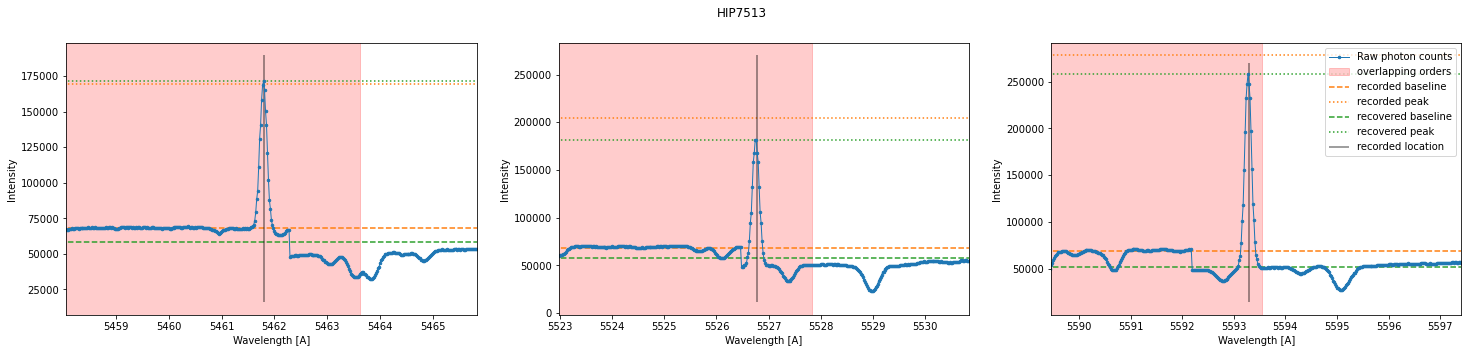

In [162]:
plt.figure(figsize = [25,5])
for order in range(3):
    print()
    print('Order ' + str(order) + ' recovered height: ' + str(recovered_peak_photons_S[order]))
    print('         injected height: ' + str(injected_peak_photons[order]))
    plt.subplot(1,3,order+1)
    low_bound = apf_wave[0].data[order + 39, 0]#500#[38,0]
    up_bound = apf_wave[0].data[order + 39, -1]#-3000#[42,-1]
    idxs_raw = (wave_soln_ref > low_bound) * (wave_soln_ref < up_bound)
    idxs_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
      
    x = wl_unshifted[idxs_unshifted]
    #plt.xlim([x[800], x[1000]])
    ms = 5; lw = 1
    plt.plot(x, photon_counts[idxs_raw], '.-', ms = ms, lw = lw, label = 'Raw photon counts')
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    # this won't work becuase the baseline is for BOTH overlapping orders combined
    plt.hlines([median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dashed', color = 'C1', alpha = 1.0, label = 'recorded baseline')
    plt.hlines([injected_peak_photons[order] + median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dotted',  color = 'C1',  alpha = 1.0, label = 'recorded peak')  
    plt.hlines([recovered_baseline_photons_S[order]], xmin = xmin, xmax = xmax, ls = 'dashed', color = 'C2', alpha = 1.0, label = 'recovered baseline')
    plt.hlines([recovered_peak_photons_S[order] + recovered_baseline_photons_S[order]], xmin = xmin, xmax = xmax, ls = 'dotted', color = 'C2', alpha = 1.0, label = 'recovered peak')  
    ax.axvspan(apf_wave[0].data[order + 39, 0], apf_wave[0].data[order + 39 - 1, -1], alpha=0.2, color='red', label = 'overlapping orders')#fill_betweenx(y, x1, x2=0,
    plt.vlines([injection_wl[order]], ymin = ymin, ymax = ymax, ls = 'solid', alpha = 0.5, label = 'recorded location')
    plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity')
    if order == 2: plt.legend()
    plt.xlim([apf_wave[0].data[order + 39, 750], apf_wave[0].data[order + 39, -3500]])
plt.suptitle(star)

### Conclusion

So, for injections at the edge of the order, the conclusion seems to be:
<ol>
  <li>The region of overlap between orders shrinks at higher orders, such that injections at the same location along a each order (ie. 1/5 of the way along the order) have differet positions relaive to the boundary of the previous (and overlapping) order, as can be seen in the plot labelled 'stacked files (zoom)' above.</li>
  <li>There is a region of 100 pixels at the very end of each order that is left alone during resampling becuase it is not used in the deblazing. In the above plot, that is the region between the sharp drop-off in flux and the edge of the red region.<li>
  <li>I happened to do my injectinos at a location very near these 100 pixels, so that the position of the injecitons shifts relative to these pixels between orders.</li>
</ol>
    This means that:
    
    
For order 39, the injection is left of the un-resampled region but close enough to it that un-resampled region (which is alwasy lower in flux than the region to the left becuase it only conatins flux from the right-hand order) draws down the calculation of the local baseline flux artificially. Lower fit baseline means the peak is recovered to be too large.


For order 40, the injection is within the un-resampled region, but close enough to the left edge of it that the correctly resample region draws the local baseline upwards. A higher fit baseline means the peak is recovered to be too low.

For order 41, the injection is now still within the un-resampled but far enough from the edge that the local baseline is calculated correctly. Thus the recovery is now not systematically offset. 
 
The way to fix this is then to re-instate resampling in that 100 pixel region. We still won't resample in that region when processing the spectrum itself (this is important for the deblazing step), but we can do it when we are only doing the resampling in order to produce the array of raw photon counts. 


The result of this is below. The recovery of the 1st and 2nd injections is greatly improved, and they no longer fall into the two separate populations observed in the recovery plot. 



In [167]:
test = '9'
key = '9'
path = 'APF_spectra/NDRS_testing_inj_' + test                                 
make_plots = False 

#injection_key_file = 'Injection_key_'  + key + '.csv'
injection_key = df #pd.read_csv(injection_key_file) --> read from modified recorded basleines above
injected_stars = injection_key['Star_name']


injected_dir = 'APF_spectra/injected_spectra_'  + key + '/'
file_list = os.listdir(injected_dir + star + '_spectra') 
try: file_list.remove('.ipynb_checkpoints')
except: pass

expected_peak_photons_S = np.zeros(len(injected_stars)) * np.nan
expected_baseline_photons_S = np.zeros(len(injected_stars)) * np.nan
expected_wl_arr_S = np.zeros(len(injected_stars)) * np.nan
recovered_peak_photons_S = np.zeros(len(injected_stars)) * np.nan
recovered_baseline_photons_S = np.zeros(len(injected_stars)) * np.nan
original_wl_arr_S = np.zeros(len(injected_stars)) * np.nan
gaia_Teff_arr =  np.zeros(len(injected_stars)) * np.nan 

j = 0 # number of injections
hdu_injected = [None] * len(file_list)
for file in file_list:
    if not '_3_injection' in file:
        print(file)
        hdu_injected[j] =  fits.open(injected_dir + star + '_spectra/' + file)
    j += 1
    
    
hdu_shifted = fits.open('APF_spectra/NDRS_testing_inj_' + test + '/' + star + '_NDRS.fits')
hdu_unshifted = fits.open('APF_spectra/NDRU_testing_inj_' + test + '/' + star + '_NDRU.fits')

photon_counts = np.array(pd.read_csv('SM_photon_counts_all_injections/test_' + key + '/photon_counts_' + star + '.csv')) # ORIGINAL: use star + '_old' + '.csv'

shifted  = hdu_shifted[0].data
wl_shifted = hdu_shifted[1].data
unshifted  = hdu_unshifted[0].data
wl_unshifted = hdu_unshifted[1].data
shift_value = float(velocity_shifts[velocity_shifts['Star_name'] == star]['Velocity_shift [km/s]'])
pixels_per_A = 1 / np.median(wl_unshifted[1:] - wl_unshifted[:-1])
pixel_shift = pixels_per_A * shift_value

expected_injections = injection_key[injection_key['Star_name'] == star]
expected_wl = list(expected_injections['Injection_wavelength'])
expected_locs = sorted(list(expected_injections['Injection_wavelength'] - expected_injections['Injection_wavelength'] * shift_value / c))


orders = [39, 40,41]  

 
for i in range(3):  # for each injection
    
    n = i # ugly, but just for this script becuase only use one star. n = total number of injection fit
    order = orders[i]
    
    try:
        gaia_source_id, id_2MASS = get_names(star)
        gaia_row = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)] # star has been run so should be here
        gaia_row = gaia_row.median(axis = 0, skipna = True)
        gaia_Teff_arr[n] = gaia_row['teff_val']
    except ValueError:
        gaia_Teff_arr[n] = np.nan

    # ----- Find the observed signal (for real signals this is done in Zoe's algorithm) -----#    
    low_bound = apf_wl_soln[order, 0] #,1000]#500#[38,0]
    up_bound = apf_wl_soln[order, -1] # -1000]#-3000#[42,-1]
    idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound)
    idxs_order_unshifted= (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
    #idxs_order_shifted_no_inj = (wl_shifted_no_inj > low_bound) * (wl_shifted_no_inj < up_bound)
    idxs_order_raw_phot = (wave_soln_ref > low_bound) * (wave_soln_ref < up_bound)

    popt, pcov = curve_fit(gaussian, wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted], 
                           bounds=([0.2, expected_locs[i] - 3, 0, 0.5], [5, expected_locs[i] + 3, 2, 1.5]))
    
    #if popt[0]  < 1.1 * popt[3]:
    #    print('Fitting observed peak with narrower window.')
    #    popt, pcov = curve_fit(gaussian, wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted], 
    #                           bounds=([0, expected_locs[i] - 0.5, 0, 0.5], [5, expected_locs[i] + 0.5, 2, 1.5]))

    
    fit_height_norm = popt[0]
    fit_peak_pos = popt[1]
    fit_width = popt[2]
    fit_baseline_flux_norm = popt[3]
    shifted_wl = fit_peak_pos + fit_peak_pos * shift_value / c
    original_loc_guess = np.absolute(wave_soln_ref - shifted_wl).argmin()
    initial_height_guess = photon_counts[original_loc_guess]
    
    
    # --------------------------- Recover the original signal -----------------------------# 
    popt2, pcov2 = curve_fit(gaussian, wl_unshifted[idxs_order_unshifted], photon_counts[idxs_order_raw_phot].flatten(), 
                           bounds=([0.8 * initial_height_guess, shifted_wl - 0.5, 0, 0], [2 * initial_height_guess, shifted_wl + 0.5, np.inf, np.inf]))
    
    if popt2[0]  < 1.1 * popt2[3]:
            print('Fitting with wider window.')
            popt2, pcov2 = curve_fit(gaussian, wl_unshifted[idxs_order_unshifted], photon_counts[idxs_order_raw_phot].flatten(), 
                           bounds=([0.8 * initial_height_guess, shifted_wl - 2, 0, 0], [2 * initial_height_guess, shifted_wl + 2, np.inf, np.inf]))
    
    original_wl = popt2[1]
    original_wl_arr_S[n] = original_wl
    original_loc = np.absolute(wave_soln_ref - original_wl).argmin()
    recovered_baseline_photons_S[n] = np.median(np.hstack([photon_counts[original_loc - 100 : original_loc - 50], photon_counts[original_loc + 50 : original_loc + 100]]))
    recovered_peak_photons_S[n] = photon_counts[original_loc] - recovered_baseline_photons_S[n] #fit_height_norm / float(scale)  
                
    #recovered_baseline_photons_S[n] = fit_baseline_flux_norm / float(scale)
    expected_peak_photons_S[n] = list(expected_injections['Injected_peak_photons'])[i]
    expected_baseline_photons_S[n] = list(expected_injections['Local_median_photons'])[i]
    expected_wl_arr_S[n] = expected_wl[i]    
    
    verbosity = 1
    if verbosity > 0:#or abs(fractional_diff_arr[n]) > 0.5:
        print()
        print(star)
        print('expected peak position: ' + str(expected_wl[i]))
        print('expected peak position shifted back: ' + str(expected_locs[i]))
        print('fit peak position: ' + str(fit_peak_pos)) 
        print('fit peak height: ' + str(popt[0])) 
        print('expected baseline: '+ str(expected_baseline_photons_S[n]))
        print('recovered peak position: ' + str(original_wl)) 
        print('wl shift: ' + str(fit_peak_pos * shift_value / c))
        print('original loc: ' + str(original_loc))
        print()
       # print('expected baseline: ' + str(expected_baseline_photons_S[n]))
       # print('recovered baseline: ' + str(recovered_baseline_photons_S[n]))

       # print('recovered peak: ' + str(recovered_peak_photons_S[n]))
        print('(fit - expected)/expected height: ' + str((recovered_peak_photons_S[n]- expected_peak_photons_S[n])/expected_peak_photons_S[n]))

    if make_plots:# | (recovered_peak_photons_S[n] < 100):
                
        plt.figure(figsize = [15,5]) 
        lw = 1    
        ms = 3
        #plt.vlines([expected_locs[i]], ymin = np.min(shifted[idxs_order_shifted]),  ymax = 1.1 * np.max(shifted[idxs_order_shifted]), ls = 'dashed', alpha = 0.5, label = 'Expected injection locations')
        plt.plot(wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted]), '.-', ms = ms, lw = lw, label = 'Normalized shifted')
        #plt.plot(wl_shifted_no_inj[idxs_order_shifted_no_inj], shifted_no_inj[idxs_order_shifted_no_inj], '.-', ms = ms, lw = lw, alpha = 0.3, label = 'Shifted spectrum (no injection)')
        plt.plot([],[], ' ', label = 'Velocity shift: ' + str(np.round(shift_value,2)) + ' km/s')
        #plt.subplot(1,3,i+1) 
       # plt.vlines([expected_locs[i]], ymin = np.min(shifted[idxs_order_shifted]),  ymax = 1.1 * np.max(shifted[idxs_order_shifted]), ls = 'dashed', alpha = 0.5, label = 'Expected injection locations')
        #plt.plot(wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted], '.-', ms = ms, lw = lw, label = 'Shifted spectrum')
        plt.plot(wl_unshifted[idxs_order_unshifted], unshifted[idxs_order_unshifted]/np.max(unshifted[idxs_order_unshifted]), '.-', ms = ms, lw = lw, label = 'Normalized unshifted')
        plt.plot(wl_unshifted[idxs_order_unshifted], photon_counts[idxs_order_raw_phot]/np.max(photon_counts[idxs_order_raw_phot]), '.-', ms = ms, lw = lw, label = 'Normalized raw counts')
        plt.plot([],[], ' ', label = 'recovered value: ' + str(np.round(recovered_peak_photons_S[n],2)))
        plt.plot([],[], ' ', label = 'expected value: ' + str(np.round(expected_peak_photons_S[n],2)))
        ymin, ymax = plt.gca().get_ylim()
        plt.vlines([fit_peak_pos], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, ls = '-.', alpha = 0.5, label = 'observed location in shifted spect/residual')  
        plt.vlines([original_wl], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, ls = 'dashed', alpha = 0.5, label = 'recovered location (with guassian fitting)')  
        plt.vlines([shifted_wl], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, ls = 'dotted', alpha = 0.5, label = 'recovered location (no gaussian fitting)')  
        plt.vlines([expected_wl[i]], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, color = 'r', alpha = 0.5, label = 'expected location')            
        xmin, xmax = plt.gca().get_xlim(); ran = xmax - xmin
        #plt.xlim([xmin + 3*ran/8, xmax - 3*ran/8])
        #plt.plot(wl_shifted_no_inj[idxs_order_shifted_no_inj], shifted_no_inj[idxs_order_shifted_no_inj], '.-', ms = ms, lw = lw, alpha = 0.3, label = 'Shifted spectrum (no injection)')
        plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity')
        #plt.plot(wl_shifted[idxs_order_shifted], gaussian(wl_shifted[idxs_order_shifted], *popt), label = 'Fit')
        plt.title(star + ' shifted spectrum, order ' + str(order))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #if i == 0: plt.xlim([5488,5492])
        #elif i == 1: plt.xlim([5553,5557])
        #elif i == 2: plt.xlim([5620,5624])

rcbg.508.fits_injected.fits
rcbg.509.fits_injected.fits
rcbg.510.fits_injected.fits

HIP7513
expected peak position: 5461.813824900171
expected peak position shifted back: 5461.248458112894
fit peak position: 5461.244841027495
fit peak height: 1.082895926822414
expected baseline: 67849.599609375
recovered peak position: 5461.792024711798
wl shift: 0.5653078902531002
original loc: 26200

(fit - expected)/expected height: 0.017230476714840133

HIP7513
expected peak position: 5526.772619756325
expected peak position shifted back: 5526.200528912474
fit peak position: 5526.199408797205
fit peak height: 2.6910574159336496
expected baseline: 68135.298828125
recovered peak position: 5526.751569309225
wl shift: 0.5720315092698387
original loc: 29683

(fit - expected)/expected height: 0.0017823038463823976

HIP7513
expected peak position: 5593.298646595918
expected peak position shifted back: 5592.7196694671675
fit peak position: 5592.7189664733905
fit peak height: 4.059064023324853
expected bas


Order 0 recovered height: 103528.02083333334
         injected height: 101774.3994140625

Order 1 recovered height: 136513.47326660156
         injected height: 136270.59765625

Order 2 recovered height: 218125.3045247396
         injected height: 208424.958984375


Text(0.5, 0.98, 'HIP7513')

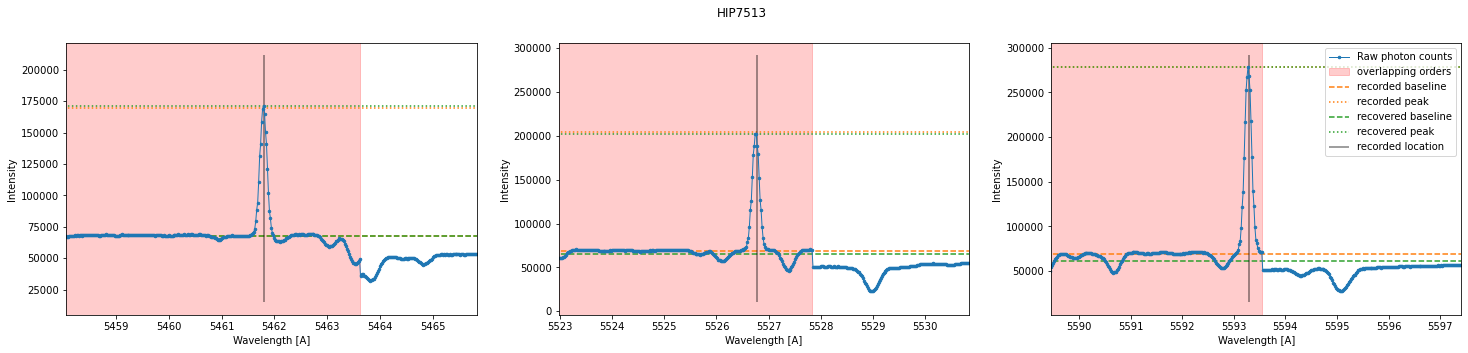

In [164]:
plt.figure(figsize = [25,5])
for order in range(3):
    print()
    print('Order ' + str(order) + ' recovered height: ' + str(recovered_peak_photons_S[order]))
    print('         injected height: ' + str(injected_peak_photons[order]))
    plt.subplot(1,3,order+1)
    low_bound = apf_wave[0].data[order + 39, 0]#500#[38,0]
    up_bound = apf_wave[0].data[order + 39, -1]#-3000#[42,-1]
    idxs_raw = (wave_soln_ref > low_bound) * (wave_soln_ref < up_bound)
    idxs_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
      
    x = wl_unshifted[idxs_unshifted]
    #plt.xlim([x[800], x[1000]])
    ms = 5; lw = 1
    plt.plot(x, photon_counts[idxs_raw], '.-', ms = ms, lw = lw, label = 'Raw photon counts')
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    # this won't work becuase the baseline is for BOTH overlapping orders combined
    plt.hlines([median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dashed', color = 'C1', alpha = 1.0, label = 'recorded baseline')
    plt.hlines([injected_peak_photons[order] + median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dotted',  color = 'C1',  alpha = 1.0, label = 'recorded peak')  
    plt.hlines([recovered_baseline_photons_S[order]], xmin = xmin, xmax = xmax, ls = 'dashed', color = 'C2', alpha = 1.0, label = 'recovered baseline')
    plt.hlines([recovered_peak_photons_S[order] + recovered_baseline_photons_S[order]], xmin = xmin, xmax = xmax, ls = 'dotted', color = 'C2', alpha = 1.0, label = 'recovered peak')  
    ax.axvspan(apf_wave[0].data[order + 39, 0], apf_wave[0].data[order + 39 - 1, -1], alpha=0.2, color='red', label = 'overlapping orders')#fill_betweenx(y, x1, x2=0,
    plt.vlines([injection_wl[order]], ymin = ymin, ymax = ymax, ls = 'solid', alpha = 0.5, label = 'recorded location')
    plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity')
    if order == 2: plt.legend()
    plt.xlim([apf_wave[0].data[order + 39, 750], apf_wave[0].data[order + 39, -3500]])
plt.suptitle(star)

### What about the order centers?

Star: HIP100017

rbak.199.fits: 
injecting signal of W = 5, H = 1.5*(98th pct level of order) = 55445.83 into order 39.
                     : injecting at center point 5490.07413621209 A
injecting signal of W = 5, H = 2*(98th pct level of order) = 75335.071 into order 40.
                     : injecting at center point 5555.36527738973 A
injecting signal of W = 5, H = 3*(98th pct level of order) = 114344.601 into order 41.
                     : injecting at center point 5622.229264717167 A

rbak.200.fits: 
injecting signal of W = 5, H = 1.5*(98th pct level of order) = 55178.169 into order 39.
                     : injecting at center point 5490.07413621209 A
injecting signal of W = 5, H = 2*(98th pct level of order) = 74923.472 into order 40.
                     : injecting at center point 5555.36527738973 A
injecting signal of W = 5, H = 3*(98th pct level of order) = 113687.594 into order 41.
                     : injecting at center point 5622.229264717167 A

rbak.201.fits: 
in

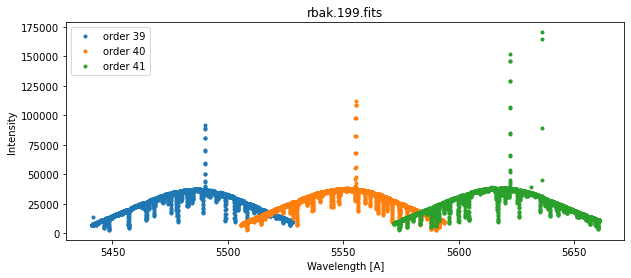

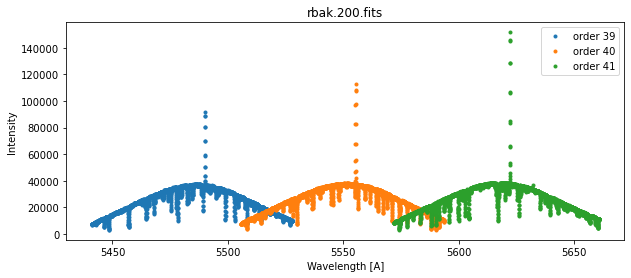

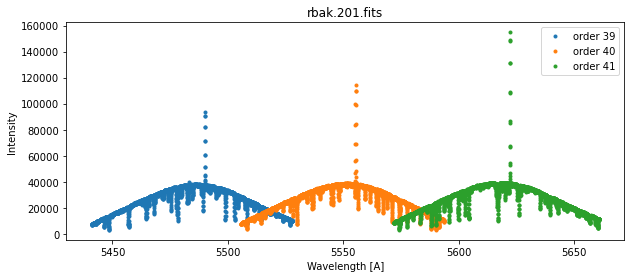

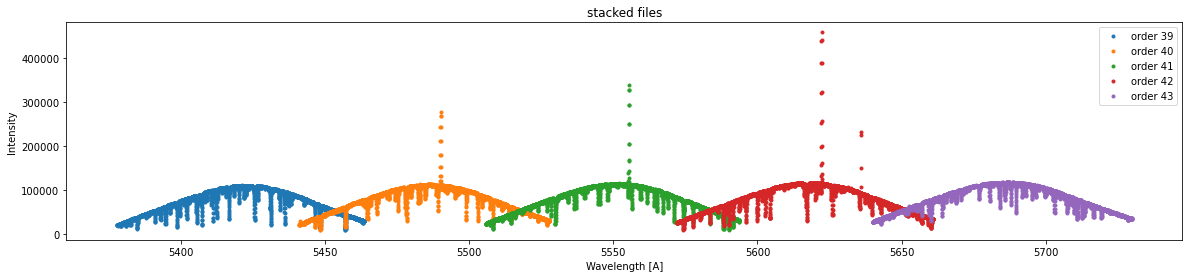

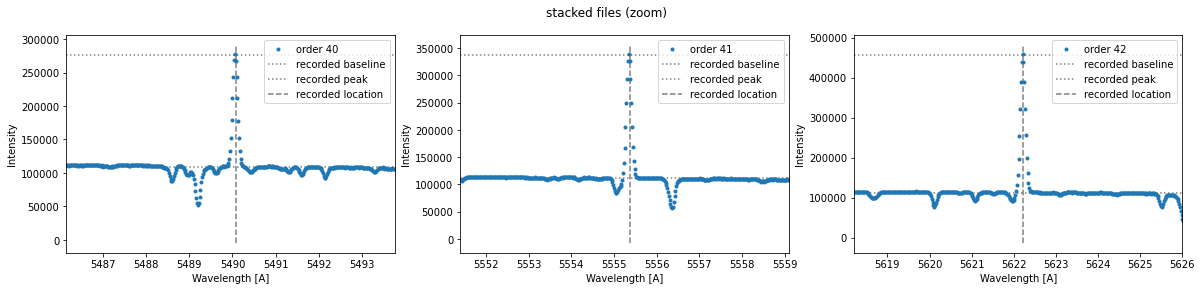

In [206]:
# ---------- Centers: ignoreing this for now ---------- #
save_key =  False
save_injected_files = False

star = 'HIP100017'#'HIP7513' #os.listdir('APF_spectra/all_apf_spectra_highest_SNR')[0:300]
test = '8'
n_stars = 1

heights = [1.5, 2, 3] # times the 98th percentile of order 40

apf_wave = fits.open('apf_wav.fits')

injected_peak_photons = np.zeros(n_stars*3) # *3 becuase three different inejctions in each star
median_photons_100_pix = np.zeros(n_stars*3)
injection_wl = np.zeros(n_stars*3)*np.nan
stars = []

for m in range(3): stars += [star] # want three entries for this star: one for each injection
dir_path = 'APF_spectra/all_apf_spectra_highest_SNR/' + star + '_spectra'
i = 0
stacked = np.zeros([5,4608])
print('Star: ' + star)
for file in os.listdir(dir_path):
    print()
    print(file + ': ')
    hdu = fits.open(dir_path + '/' + file)# , mode='update')
    spectrum = np.copy(hdu[0].data)
    color = 'C' + str(i)  
    n = 0
    orders = [39, 40, 41]
    y = hdu[0].data
    plt.figure(figsize = [10,4])
    for height in heights:
        order = orders[n] # inject the 1.5 hieght into order 39, 2 into order 40, etc
        y_order = y[order]
        x = apf_wave[0].data[order]
        h = height - 1 # becuase in the above implementation we add to the baseline, so ie. h = 1 injects a guassian whose peak is at twice the pixels value of the 98th percentile
        print('injecting signal of W = 5, H = ' + str(height) + 
              '*(98th pct level of order) = ' + str(np.round(height * np.percentile(y_order,98),3)) + ' into order ' + str(order) + '.')  
        frac = 2
        median_100 = np.median(y_order[int(len(y_order)/frac - 50): int(len(y_order)/frac + 50)])
        y_new = insert_gaussian(y_order, [height*np.percentile(y_order,98), 49, 5, 0], int(len(y_order)/frac), 100)
        injection_center_wl = apf_wave[0].data[order][int(len(y_order)/frac)]
        print('                     : injecting at center point ' + str(injection_center_wl) + ' A')
        
        plt.plot(x, y_new[:-1], '.', label = 'order ' + str(order))
        plt.title(file)
        plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity'); plt.legend()
        
        injected_peak_photons[n] = injected_peak_photons[n] + height * np.percentile(y_order,98) # sum over each file
        median_photons_100_pix[n] = median_photons_100_pix[n] + median_100 # sum over each file
        injection_wl[n] = injection_center_wl # same for each file (and each star)
        spectrum[order,:] = y_new
        # add each file
        stacked[order - 39 + 1,:] += y_new # the plus 1 is becuase stacked contains the two adjacent orders as well
        
        n += 1
    
    stacked[0] += y[38]
    stacked[4] += y[42]
        
    i += 1

    if save_injected_files:
        new_header = hdu[0].header # get header
        new_header.set('Injected', 'YES','Spectrum contains injected gaussian for testing.')
        data_hdu = fits.PrimaryHDU(spectrum, new_header) 
        hdu_new = fits.HDUList([data_hdu])
        out_path = 'APF_spectra/injected_spectra_9/'
        if not os.path.isdir(out_path + star + '_spectra/'):
            os.mkdir(out_path + star + '_spectra/')
        hdu_new.writeto(out_path + star + '_spectra/' + file + '_injected' + '.fits')
        hdu.close()
    

plt.figure(figsize = [20,4])
for order in [0, 1, 2, 3, 4]:
    plt.plot(apf_wave[0].data[order + 38], stacked[order,:-1], '.', label = 'order ' + str(order + 39))
    plt.title('stacked files')
    plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity'); plt.legend()
    
plt.figure(figsize = [20,4])
for order in [1, 2, 3]:
    plt.subplot(1,3,order)
    x1 = apf_wave[0].data[order + 38]
    plt.xlim([x1[2100], x1[2500]])
    plt.plot(x1, stacked[order,:-1], '.', label = 'order ' + str(order + 39))
    ymin, ymax = plt.gca().get_ylim()
    xmin, xmax = plt.gca().get_xlim()
    # this won't work becuase the baseline is for BOTH overlapping orders combined
    plt.hlines([median_photons_100_pix[order -1]], xmin = xmin, xmax = xmax, ls = 'dotted', alpha = 0.5, label = 'recorded baseline')
    plt.hlines([injected_peak_photons[order -1] + median_photons_100_pix[order-1]], xmin = xmin, xmax = xmax, ls = 'dotted', alpha = 0.5, label = 'recorded peak')  
    plt.vlines([injection_wl[order - 1]], ymin = ymin, ymax = ymax, ls = 'dashed', alpha = 0.5, label = 'recorded location')
    plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity'); plt.legend()
plt.suptitle('stacked files (zoom)')

save_data = list(zip(stars, injection_wl, injected_peak_photons, median_photons_100_pix))
df = pd.DataFrame(save_data,
          columns = ['Star_name', 'Injection_wavelength', 'Injected_peak_photons', 'Local_median_photons'])
if save_key:
    if os.path.exists('Injection_key_9.csv'):
        df.to_csv('Injection_key_9.csv', mode='a', index = False, header=False)
    else:
        df.to_csv('Injection_key_9.csv', index = False)
    

In [207]:
test = '8'
key = '3'
path = 'APF_spectra/NDRS_testing_inj_' + test                                 
make_plots = False 

#injection_key_file = 'Injection_key_'  + key + '.csv'
injection_key = df #pd.read_csv(injection_key_file) --> read from modified recorded basleines above
injected_stars = injection_key['Star_name']


injected_dir = 'APF_spectra/injected_spectra_'  + key + '/'
file_list = os.listdir(injected_dir + star + '_spectra') 
try: file_list.remove('.ipynb_checkpoints')
except: pass

expected_peak_photons_S = np.zeros(len(injected_stars)) * np.nan
expected_baseline_photons_S = np.zeros(len(injected_stars)) * np.nan
expected_wl_arr_S = np.zeros(len(injected_stars)) * np.nan
recovered_peak_photons_S = np.zeros(len(injected_stars)) * np.nan
recovered_baseline_photons_S = np.zeros(len(injected_stars)) * np.nan
original_wl_arr_S = np.zeros(len(injected_stars)) * np.nan
gaia_Teff_arr =  np.zeros(len(injected_stars)) * np.nan 

j = 0 # number of injections
hdu_injected = [None] * len(file_list)
for file in file_list:
    if not '_3_injection' in file:
        print(file)
        hdu_injected[j] =  fits.open(injected_dir + star + '_spectra/' + file)
    j += 1
    
    
hdu_shifted = fits.open('APF_spectra/NDRS_testing_inj_' + test + '/' + star + '_NDRS.fits')
hdu_unshifted = fits.open('APF_spectra/NDRU_testing_inj_' + test + '/' + star + '_NDRU.fits')

photon_counts = np.array(pd.read_csv('SM_photon_counts_all_injections/test_' + key + '/photon_counts_' + star + '.csv')) # ORIGINAL: use star + '_old' + '.csv'

shifted  = hdu_shifted[0].data
wl_shifted = hdu_shifted[1].data
unshifted  = hdu_unshifted[0].data
wl_unshifted = hdu_unshifted[1].data
shift_value = float(velocity_shifts[velocity_shifts['Star_name'] == star]['Velocity_shift [km/s]'])
pixels_per_A = 1 / np.median(wl_unshifted[1:] - wl_unshifted[:-1])
pixel_shift = pixels_per_A * shift_value

expected_injections = injection_key[injection_key['Star_name'] == star]
expected_wl = list(expected_injections['Injection_wavelength'])
expected_locs = sorted(list(expected_injections['Injection_wavelength'] - expected_injections['Injection_wavelength'] * shift_value / c))


orders = [39, 40,41]  
 
for i in range(3):  # for each injection
    
    n = i # ugly, but just for this script becuase only use one star. n = total number of injection fit
    order = orders[i]
    
    try:
        gaia_source_id, id_2MASS = get_names(star)
        gaia_row = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)] # star has been run so should be here
        gaia_row = gaia_row.median(axis = 0, skipna = True)
        gaia_Teff_arr[n] = gaia_row['teff_val']
    except ValueError:
        gaia_Teff_arr[n] = np.nan

    # ----- Find the observed signal (for real signals this is done in Zoe's algorithm) -----#    
    low_bound = apf_wl_soln[order, 0] #,1000]#500#[38,0]
    up_bound = apf_wl_soln[order, -1] # -1000]#-3000#[42,-1]
    idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound)
    idxs_order_unshifted= (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
    #idxs_order_shifted_no_inj = (wl_shifted_no_inj > low_bound) * (wl_shifted_no_inj < up_bound)
    idxs_order_raw_phot = (wave_soln_ref > low_bound) * (wave_soln_ref < up_bound)

    popt, pcov = curve_fit(gaussian, wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted], 
                           bounds=([0.2, expected_locs[i] - 3, 0, 0.5], [5, expected_locs[i] + 3, 2, 1.5]))
    
    #if popt[0]  < 1.1 * popt[3]:
    #    print('Fitting observed peak with narrower window.')
    #    popt, pcov = curve_fit(gaussian, wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted], 
    #                           bounds=([0, expected_locs[i] - 0.5, 0, 0.5], [5, expected_locs[i] + 0.5, 2, 1.5]))

    
    fit_height_norm = popt[0]
    fit_peak_pos = popt[1]
    fit_width = popt[2]
    fit_baseline_flux_norm = popt[3]
    shifted_wl = fit_peak_pos + fit_peak_pos * shift_value / c
    original_loc_guess = np.absolute(wave_soln_ref - shifted_wl).argmin()
    initial_height_guess = photon_counts[original_loc_guess]
    
    
    # --------------------------- Recover the original signal -----------------------------# 
    popt2, pcov2 = curve_fit(gaussian, wl_unshifted[idxs_order_unshifted], photon_counts[idxs_order_raw_phot].flatten(), 
                           bounds=([0.8 * initial_height_guess, shifted_wl - 0.5, 0, 0], [2 * initial_height_guess, shifted_wl + 0.5, np.inf, np.inf]))
    
    if popt2[0]  < 1.1 * popt2[3]:
            print('Fitting with wider window.')
            popt2, pcov2 = curve_fit(gaussian, wl_unshifted[idxs_order_unshifted], photon_counts[idxs_order_raw_phot].flatten(), 
                           bounds=([0.8 * initial_height_guess, shifted_wl - 2, 0, 0], [2 * initial_height_guess, shifted_wl + 2, np.inf, np.inf]))
    
    original_wl = popt2[1]
    original_wl_arr_S[n] = original_wl
    original_loc = np.absolute(wave_soln_ref - original_wl).argmin()
    recovered_baseline_photons_S[n] = np.median(np.hstack([photon_counts[original_loc - 100 : original_loc - 50], photon_counts[original_loc + 50 : original_loc + 100]]))
    recovered_peak_photons_S[n] = photon_counts[original_loc] - recovered_baseline_photons_S[n] #fit_height_norm / float(scale)  
                
    #recovered_baseline_photons_S[n] = fit_baseline_flux_norm / float(scale)
    expected_peak_photons_S[n] = list(expected_injections['Injected_peak_photons'])[i]
    expected_baseline_photons_S[n] = list(expected_injections['Local_median_photons'])[i]
    expected_wl_arr_S[n] = expected_wl[i]    
    
    verbosity = 1
    if verbosity > 0:#or abs(fractional_diff_arr[n]) > 0.5:
        print()
        print(star)
        print('expected peak position: ' + str(expected_wl[i]))
        print('expected peak position shifted back: ' + str(expected_locs[i]))
        print('fit peak position: ' + str(fit_peak_pos)) 
        print('fit peak height: ' + str(popt[0])) 
        print('expected baseline: '+ str(expected_baseline_photons_S[n]))
        print('recovered peak position: ' + str(original_wl)) 
        print('wl shift: ' + str(fit_peak_pos * shift_value / c))
        print('original loc: ' + str(original_loc))
        print()
       # print('expected baseline: ' + str(expected_baseline_photons_S[n]))
       # print('recovered baseline: ' + str(recovered_baseline_photons_S[n]))

       # print('recovered peak: ' + str(recovered_peak_photons_S[n]))
        print('(fit - expected)/expected height: ' + str((recovered_peak_photons_S[n]- expected_peak_photons_S[n])/expected_peak_photons_S[n]))

    if make_plots:# | (recovered_peak_photons_S[n] < 100):
                
        plt.figure(figsize = [15,5]) 
        lw = 1    
        ms = 3
        #plt.vlines([expected_locs[i]], ymin = np.min(shifted[idxs_order_shifted]),  ymax = 1.1 * np.max(shifted[idxs_order_shifted]), ls = 'dashed', alpha = 0.5, label = 'Expected injection locations')
        plt.plot(wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted]), '.-', ms = ms, lw = lw, label = 'Normalized shifted')
        #plt.plot(wl_shifted_no_inj[idxs_order_shifted_no_inj], shifted_no_inj[idxs_order_shifted_no_inj], '.-', ms = ms, lw = lw, alpha = 0.3, label = 'Shifted spectrum (no injection)')
        plt.plot([],[], ' ', label = 'Velocity shift: ' + str(np.round(shift_value,2)) + ' km/s')
        #plt.subplot(1,3,i+1) 
       # plt.vlines([expected_locs[i]], ymin = np.min(shifted[idxs_order_shifted]),  ymax = 1.1 * np.max(shifted[idxs_order_shifted]), ls = 'dashed', alpha = 0.5, label = 'Expected injection locations')
        #plt.plot(wl_shifted[idxs_order_shifted], shifted[idxs_order_shifted], '.-', ms = ms, lw = lw, label = 'Shifted spectrum')
        plt.plot(wl_unshifted[idxs_order_unshifted], unshifted[idxs_order_unshifted]/np.max(unshifted[idxs_order_unshifted]), '.-', ms = ms, lw = lw, label = 'Normalized unshifted')
        plt.plot(wl_unshifted[idxs_order_unshifted], photon_counts[idxs_order_raw_phot]/np.max(photon_counts[idxs_order_raw_phot]), '.-', ms = ms, lw = lw, label = 'Normalized raw counts')
        plt.plot([],[], ' ', label = 'recovered value: ' + str(np.round(recovered_peak_photons_S[n],2)))
        plt.plot([],[], ' ', label = 'expected value: ' + str(np.round(expected_peak_photons_S[n],2)))
        ymin, ymax = plt.gca().get_ylim()
        plt.vlines([fit_peak_pos], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, ls = '-.', alpha = 0.5, label = 'observed location in shifted spect/residual')  
        plt.vlines([original_wl], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, ls = 'dashed', alpha = 0.5, label = 'recovered location (with guassian fitting)')  
        plt.vlines([shifted_wl], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, ls = 'dotted', alpha = 0.5, label = 'recovered location (no gaussian fitting)')  
        plt.vlines([expected_wl[i]], ymin = np.min(shifted[idxs_order_shifted]/np.max(shifted[idxs_order_shifted])),  ymax = ymax, color = 'r', alpha = 0.5, label = 'expected location')            
        xmin, xmax = plt.gca().get_xlim(); ran = xmax - xmin
        #plt.xlim([xmin + 3*ran/8, xmax - 3*ran/8])
        #plt.plot(wl_shifted_no_inj[idxs_order_shifted_no_inj], shifted_no_inj[idxs_order_shifted_no_inj], '.-', ms = ms, lw = lw, alpha = 0.3, label = 'Shifted spectrum (no injection)')
        plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity')
        #plt.plot(wl_shifted[idxs_order_shifted], gaussian(wl_shifted[idxs_order_shifted], *popt), label = 'Fit')
        plt.title(star + ' shifted spectrum, order ' + str(order))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #if i == 0: plt.xlim([5488,5492])
        #elif i == 1: plt.xlim([5553,5557])
        #elif i == 2: plt.xlim([5620,5624])

rbak.199.fits_injected.fits
rbak.200.fits_injected.fits
rbak.201.fits_injected.fits

HIP100017
expected peak position: 5490.07413621209
expected peak position shifted back: 5488.602166544625
fit peak position: 5488.610093521714
fit peak height: 1.4776251614473173
expected baseline: 108566.1171875
recovered peak position: 5490.053887434429
wl shift: 1.471577136074875
original loc: 27720

(fit - expected)/expected height: -0.006576608518848945

HIP100017
expected peak position: 5555.36527738973
expected peak position shifted back: 5553.875802206496
fit peak position: 5553.888449511359
fit peak height: 1.9894318038840846
expected baseline: 111389.01171875
recovered peak position: 5555.348625168311
wl shift: 1.4890792239474135
original loc: 31204

(fit - expected)/expected height: 0.006848887734724763

HIP100017
expected peak position: 5622.229264717167
expected peak position shifted back: 5620.721862314965
fit peak position: 5620.737984031134
fit peak height: 2.938538337647521
expected ba


Order 0 recovered height: 166149.4306640625
         injected height: 167249.3642578125

Order 1 recovered height: 228583.0576171875
         injected height: 227028.1671875

Order 2 recovered height: 336660.263671875
         injected height: 344503.89023437497


Text(0.5, 0.98, 'HIP100017')

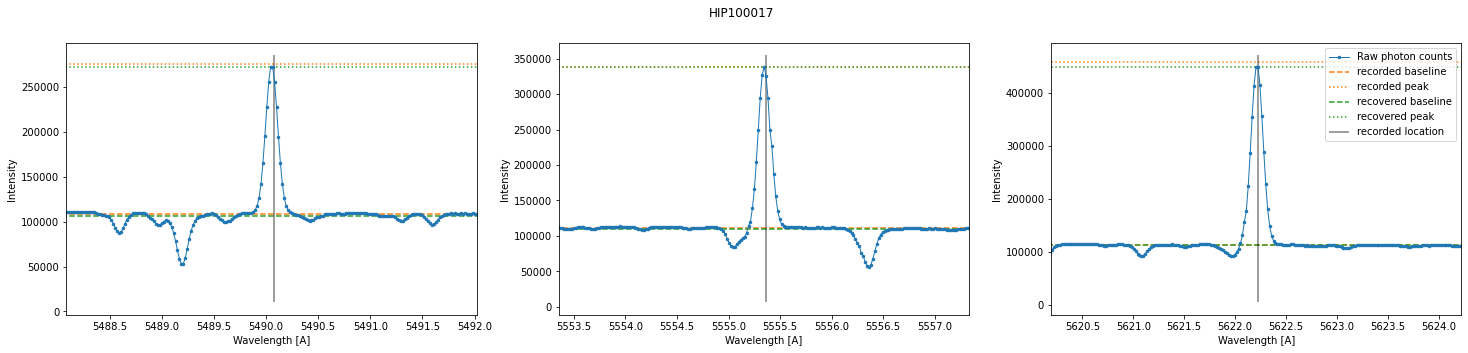

In [208]:
plt.figure(figsize = [25,5])
for order in range(3):
    print()
    print('Order ' + str(order) + ' recovered height: ' + str(recovered_peak_photons_S[order]))
    print('         injected height: ' + str(injected_peak_photons[order]))
    plt.subplot(1,3,order+1)
    low_bound = apf_wave[0].data[order + 39, 0]#500#[38,0]
    up_bound = apf_wave[0].data[order + 39, -1]#-3000#[42,-1]
    idxs_raw = (wave_soln_ref > low_bound) * (wave_soln_ref < up_bound)
    idxs_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
      
    x = wl_unshifted[idxs_unshifted]
    #plt.xlim([x[800], x[1000]])
    ms = 5; lw = 1
    plt.plot(x, photon_counts[idxs_raw], '.-', ms = ms, lw = lw, label = 'Raw photon counts')
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    # this won't work becuase the baseline is for BOTH overlapping orders combined
    plt.hlines([median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dashed', color = 'C1', alpha = 1.0, label = 'recorded baseline')
    plt.hlines([injected_peak_photons[order] + median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dotted',  color = 'C1',  alpha = 1.0, label = 'recorded peak')  
    plt.hlines([recovered_baseline_photons_S[order]], xmin = xmin, xmax = xmax, ls = 'dashed', color = 'C2', alpha = 1.0, label = 'recovered baseline')
    plt.hlines([recovered_peak_photons_S[order] + recovered_baseline_photons_S[order]], xmin = xmin, xmax = xmax, ls = 'dotted', color = 'C2', alpha = 1.0, label = 'recovered peak')  
    #ax.axvspan(apf_wave[0].data[order + 39, 0], apf_wave[0].data[order + 39 - 1, -1], alpha=0.2, color='red', label = 'overlapping orders')#fill_betweenx(y, x1, x2=0,
    plt.vlines([injection_wl[order]], ymin = ymin, ymax = ymax, ls = 'solid', alpha = 0.5, label = 'recorded location')
    plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity')
    if order == 2: plt.legend()
    plt.xlim([apf_wave[0].data[order + 39, 2200], apf_wave[0].data[order + 39, -2200]])
plt.suptitle(star)

In [ ]:
# make a plot demonstrating injection and recovery for the paper/poster
'''
plt.figure(figsize = [15,8])
for order in range(1):
    print()
    print('Order ' + str(order) + ' recovered height: ' + str(recovered_peak_photons_S[order]))
    print('         injected height: ' + str(injected_peak_photons[order]))
    plt.subplot(1,3,order+1)
    low_bound = apf_wave[0].data[order + 39, 0]#500#[38,0]
    up_bound = apf_wave[0].data[order + 39, -1]#-3000#[42,-1]
    idxs_raw = (wave_soln_ref > low_bound) * (wave_soln_ref < up_bound)
    idxs_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
    idxs_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound)
      
    x = wl_unshifted[idxs_unshifted]
    #plt.xlim([x[800], x[1000]])
    ms = 5; lw = 1
    plt.plot(x, photon_counts[idxs_raw], '.-', ms = ms, lw = lw, label = 'Raw photon counts')
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    # this won't work becuase the baseline is for BOTH overlapping orders combined
    plt.hlines([median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dashed', color = 'C1', alpha = 1.0, label = 'recorded baseline')
    plt.hlines([injected_peak_photons[order] + median_photons_100_pix[order]], xmin = xmin, xmax = xmax, ls = 'dotted',  color = 'C1',  alpha = 1.0, label = 'recorded peak')  
    plt.hlines([recovered_baseline_photons_S[order]], xmin = xmin, xmax = xmax, ls = 'dashed', color = 'C2', alpha = 1.0, label = 'recovered baseline')
    plt.hlines([recovered_peak_photons_S[order] + recovered_baseline_photons_S[order]], xmin = xmin, xmax = xmax, ls = 'dotted', color = 'C2', alpha = 1.0, label = 'recovered peak')  
    #ax.axvspan(apf_wave[0].data[order + 39, 0], apf_wave[0].data[order + 39 - 1, -1], alpha=0.2, color='red', label = 'overlapping orders')#fill_betweenx(y, x1, x2=0,
    plt.vlines([injection_wl[order]], ymin = ymin, ymax = ymax, ls = 'solid', alpha = 0.5, label = 'recorded location')
    plt.xlabel('Wavelength [A]'); plt.ylabel('Intensity')
    if order == 2: plt.legend()
    plt.xlim([apf_wave[0].data[order + 39, 2200], apf_wave[0].data[order + 39, -2200]])
plt.suptitle(star)
'''